## Prepping features dataset


Things to look at:
1. We are currently dropping NA in Demand, Temp. and Humidity. --> Temp and humidity is given each 5 minutes, fill up temp. and humidity with average. 
2. Normalization
3. Demand values we have:
12/31/2018  21:15:00  upandincluding 10/11/2021/ 6:07:00
4. Predicting the demand from 
10/11/2021/ 6:08 upandincluding 12/13/2021  17:59:00 

In [1]:
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit

In [2]:
import math, datetime, time, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import itertools
import tqdm
from prophet import Prophet


def load_data(data_path):
  data = pd.read_csv(data_path)  
  return data

inbound = load_data("inbound_loads.csv")
outbound = load_data("outbound_laods.csv")
weather = load_data("weather.csv")
#For loop to ensure that all pallet data is in the same dataframe
pallet = load_data("Pallet_history_Gold_Spike[0].csv")
for x in range(1, 10):
    pallet = pd.concat([pallet, load_data(f"Pallet_history_Gold_Spike[{x}].csv")])
trainentest = load_data("demand_kWtrain_val.csv")
train = trainentest.iloc[:273988,:]
test = trainentest.iloc[273988:, :]

pallet = pallet.drop(['lot_code', 
                      'tran_type', 
                      'final_pallet_code', 
                      'warehouse_facility_id',
                      'source_system_id'], axis=1)

Importing plotly failed. Interactive plots will not work.


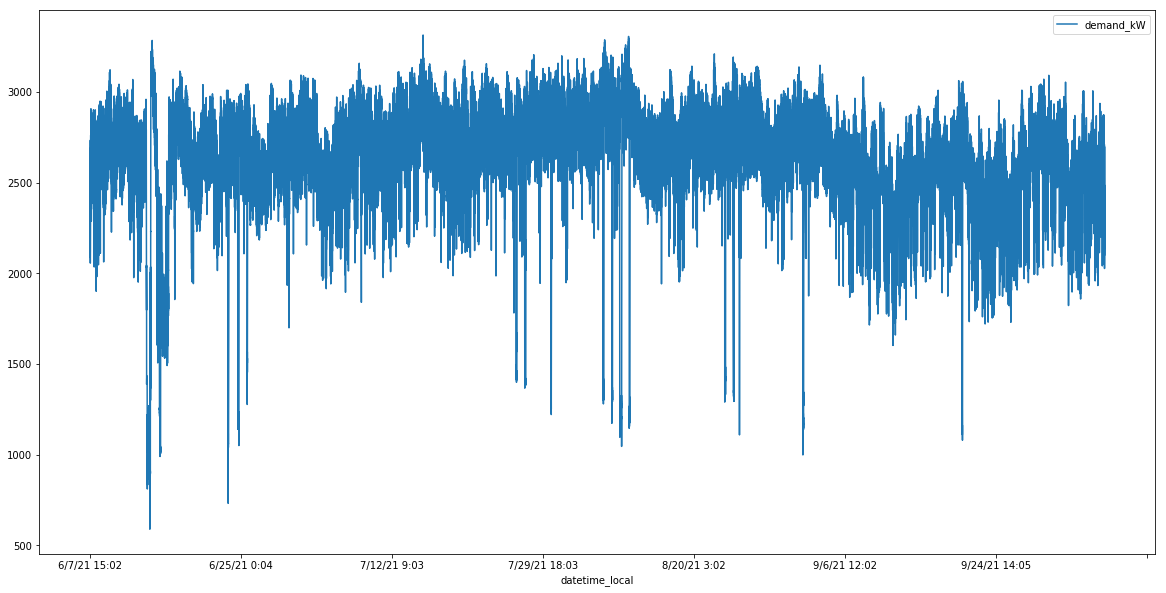

In [3]:
trainentest[100000:268000].plot('datetime_local', 'demand_kW', figsize = (20,10))

In [4]:
def addtimecol(df, colname): ####input df and colname 
    df[colname] = pd.to_datetime(df[colname])         
    df['year'] = df[colname].dt.year
    df['month'] = df[colname].dt.month
    df['weekday'] = df[colname].dt.weekday
    df['day'] = df[colname].dt.day
    df['hour'] = df[colname].dt.hour
    df['minute'] = df[colname].dt.minute        
    return df
def weekend(x):
    if x['weekday'] > 4:
        return True
    return False
    

Incoming weight feature preprocessing

In [5]:
###Incoming weight feature preprocessing
#load all data
incoming_weight_1h = load_data('incoming_weight_df_1h.csv')
incoming_weight_5h = load_data('incoming_weight_df_5h.csv')
incoming_weight_10h = load_data('incoming_weight_df_10h.csv')
incoming_weight_23h = load_data('incoming_weight_df.csv')
#rename columns 
incoming_weight_5h = incoming_weight_5h.rename(columns = {'weight_23h' : 'weight_5h'})
incoming_weight_1h = incoming_weight_1h.rename(columns = {'weight_23h' : 'weight_1h'})
incoming_weight_10h = incoming_weight_10h.rename(columns = {'weight_23h' : 'weight_10h'})
#get them to a datetime object
incoming_weight_1h['datetime_local'] = pd.to_datetime(incoming_weight_1h['datetime_local'])
incoming_weight_5h['datetime_local'] = pd.to_datetime(incoming_weight_5h['datetime_local'])
incoming_weight_10h['datetime_local'] = pd.to_datetime(incoming_weight_10h['datetime_local'])
incoming_weight_23h['datetime_local'] = pd.to_datetime(incoming_weight_23h['datetime_local'])
#set index to be datetime
incoming_weight_1h.set_index('datetime_local', inplace=True)
incoming_weight_5h.set_index('datetime_local', inplace=True)
incoming_weight_10h.set_index('datetime_local', inplace=True)
incoming_weight_23h.set_index('datetime_local', inplace=True)
#reshape them to start at 2018-31-12 9:15PM
incoming_weight_1h = incoming_weight_1h[2361:]
incoming_weight_5h = incoming_weight_5h[2330:] 
incoming_weight_10h = incoming_weight_10h[2326:]
incoming_weight_23h = incoming_weight_23h[2323:]
#Drop duplicates
incoming_weight_1h = incoming_weight_1h.loc[~incoming_weight_1h.index.duplicated()]
incoming_weight_5h = incoming_weight_5h.loc[~incoming_weight_5h.index.duplicated()]
incoming_weight_10h = incoming_weight_10h.loc[~incoming_weight_10h.index.duplicated()]
incoming_weight_23h = incoming_weight_23h.loc[~incoming_weight_23h.index.duplicated()]


Prepare the pallet movement feature

In [6]:
#load data
pallet_move_5min = load_data('pallet_movement_5min_ft.csv')
#rename column
pallet_move_5min.rename(columns = {'quantity' : 'pallet_movement_5min'}, inplace = True)
#make index a datetime object and set as index
pallet_move_5min['datetime_local'] = pd.to_datetime(pallet_move_5min['datetime_local'])
pallet_move_5min.set_index('datetime_local', inplace = True)
#delete duplicates
pallet_move_5min = pallet_move_5min.loc[~pallet_move_5min.index.duplicated()]

Do the same for doors

In [7]:
base_door = load_data("feature_inbound_outbound_door_open.csv")
base_door = base_door.rename(columns = {'total' : 'doors_open'})
base_door['datetime_local'] = pd.to_datetime(base_door['datetime_local'])
base_door.set_index('datetime_local', inplace=True)

In [8]:
#Create new dummy dfs
base_df = train.copy()
base_weather = weather.copy()

#Remove unnecessary columns
base_df = base_df.drop('Unnamed: 0', axis=1)
base_weather = base_weather.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
base_weather["localstrptime"]= pd.to_datetime(base_weather["localstrptime"])
base_df['datetime_local'] = pd.to_datetime(base_df['datetime_local'])
base_weather = base_weather.rename(columns={'localstrptime':'datetime_local'})
#base_weather['datetime_local'] = [datetime.datetime.strptime(x, 'yyyy/MM/dd HH:mm:SS') for x in base_weather['localstrptime']]

#Add pallet movements feature
##

#Add time columns.
addtimecol(base_df, 'datetime_local')

#Set index to datetime
base_df.set_index('datetime_local', inplace=True)
base_weather.set_index('datetime_local', inplace=True)

#Concatenate the weather DataFrame to the base DataFrame 
base_df = pd.concat([base_df, base_weather], axis=1)

#Concatenate the incoming weight dataframe with the base dataframe
base_df = pd.concat([base_df, incoming_weight_1h], axis=1)
base_df = pd.concat([base_df, incoming_weight_5h], axis=1)
base_df = pd.concat([base_df, incoming_weight_10h], axis=1)
base_df = pd.concat([base_df, incoming_weight_23h], axis=1)

#Concatenate the pallet movement feature
base_df = pd.concat([base_df, pallet_move_5min], axis = 1)

#Concatenate the door feature
base_df = pd.concat([base_df, base_door], axis=1)


Dummy drops things that are NA, maybe sth to look at

In [9]:
#dummy_df = base_df.dropna(subset=['demand_kW', 'Temperature', 'Relative Humidity']) 

dummy_df = base_df.copy()
dummy_df = dummy_df.reset_index()
dummy_df = dummy_df.drop(['hour'], axis=1)
dummy_df = dummy_df.drop(['datetime'], axis=1)
dummy_df = dummy_df.drop(['datetime_local'], axis=1)
dummy_df = dummy_df.drop(['datetime_UTC'], axis=1)
dummy_df

dummy_normalized_df = dummy_df.copy()
#Still drop demand_kW NaNs
#dummy_normalized_df = dummy_normalized_df.dropna(subset=['demand_kW'], axis=0)

## Create df to feed to the model

1. create df per minute and ffill in missing values


- Interpolate columns with missing values
- Normalizing columns (Min-max Normalization)
- One-hot encoding categorical columns



2. create time_series dataframe with features that are socalled lags. They contain data about the value of said feature a timespan ago.


### 1. Create new_df  

In [ ]:
new_df


In [10]:
new_df = base_df.reindex(pd.date_range(start=base_df.index.min(),
                                                  end=base_df.index.max(),
                                                  freq='1min'))
new_df = new_df.drop(['hour', 'day', 'datetime', 'datetime_UTC', 'minute'], axis=1)
print(new_df.columns)

Index(['demand_kW', 'year', 'month', 'weekday', 'Relative Humidity',
       'Temperature', 'weight_1h', 'weight_5h', 'weight_10h', 'weight_23h',
       'pallet_movement_5min', 'doors_open'],
      dtype='object')


In [11]:
def normalize_column(df, columnname):
    """Function which returns a Dataframe where the given column is normalized through min-max normalization."""
    df[f'{columnname}_normalized'] = (df[columnname] - df[columnname].min()) / (df[columnname].max() - df[columnname].min())
    return df.drop([columnname], axis=1)

def add_one_hot_encoder(df, colname):
    """
    Function which returns a DataFrame where the given column has been removed and replaced by
    one-hot-encoding columns for each value in the original column.
    """
    onehot = pd.get_dummies(df[colname], prefix=colname)
    return df.drop(colname, axis=1).join(onehot)

def interpolate_column(df, colname):
    df[f'{colname}_interpolated'] = df[colname].interpolate(method='linear')
    return df.drop([colname], axis=1)

In [12]:
interpolate = ['Temperature', 'Relative Humidity', 'demand_kW']
to_normalize = ['Relative Humidity_interpolated', 'Temperature_interpolated', 'weight_1h',  
                'weight_5h', 'weight_10h', 'weight_23h', 'pallet_movement_5min', 'doors_open']
add_one_hot_encoding = ['weekday', 'year', 'month']


for x in interpolate:
    dummy_normalized_df = interpolate_column(dummy_normalized_df, x)
    new_df = interpolate_column(new_df, x)
for x in to_normalize:
    dummy_normalized_df = normalize_column(dummy_normalized_df, x)
    new_df = normalize_column(new_df, x)
for x in add_one_hot_encoding:
    dummy_normalized_df = add_one_hot_encoder(dummy_normalized_df, x)
    new_df = add_one_hot_encoder(new_df, x)

##### New_df contains all datapoints and missing data is filled in, then dropped. 

In [13]:
new_df.rename(columns={'demand_kW_interpolated':'demand_kW'}, inplace=True)
new_df = new_df.dropna(subset = ['demand_kW', 'weight_1h_normalized', 'doors_open_normalized', 'pallet_movement_5min_normalized'], axis=0)

In [14]:
###This must be zero all across the board
new_df.resample('1min').last()
for x in new_df.columns:
    print(x, new_df[x].isna().sum())

demand_kW 0
Relative Humidity_interpolated_normalized 0
Temperature_interpolated_normalized 0
weight_1h_normalized 0
weight_5h_normalized 0
weight_10h_normalized 0
weight_23h_normalized 0
pallet_movement_5min_normalized 0
doors_open_normalized 0
weekday_0.0 0
weekday_1.0 0
weekday_2.0 0
weekday_3.0 0
weekday_4.0 0
weekday_5.0 0
weekday_6.0 0
year_2018.0 0
year_2019.0 0
year_2020.0 0
year_2021.0 0
month_1.0 0
month_2.0 0
month_3.0 0
month_4.0 0
month_5.0 0
month_6.0 0
month_7.0 0
month_8.0 0
month_9.0 0
month_10.0 0
month_11.0 0
month_12.0 0


### 2. Create timeseries dummy for prophet and dummy for timeseries + method for adding lags of a cycle we want to model
##### timeseries_dummy only consists of the range of dates we have for which we have information per minute, because timeseries need to have regular intervals. 


In [15]:
### create timeseries_dummy 
starttime = trainentest['datetime_local'].at[79678]
startime = pd.to_datetime(starttime)
onlyminutesstep1 = base_df[:1460735]
onlyminutes = onlyminutesstep1.loc[starttime:]
timeseries_dummy = onlyminutes.copy()

### Create rows for missing minutes
timeseries_dummy = timeseries_dummy.asfreq(freq = 'T', method = 'pad')

### about 6900 random rows don't have demand, ffill is fill them with the previous amount
timeseries_dummy['demand_kW'] = timeseries_dummy.demand_kW.fillna(method = 'ffill', axis = 0)
prophet_dummy = pd.DataFrame({'ds': timeseries_dummy.index, 'y' : timeseries_dummy['demand_kW']})
prophet_dummy = prophet_dummy.reset_index()
prophet_dummy.drop(['datetime_local'], axis = 1, inplace = True)

### edit timeseries_dummy just as dummy_dataset
timeseries_dummy.reset_index(inplace = True)
timeseries_dummy.drop(['hour'], axis=1, inplace = True)
timeseries_dummy.drop(['datetime'], axis=1, inplace = True)
timeseries_dummy.drop(['datetime_local'], axis=1, inplace = True)
timeseries_dummy.drop(['datetime_UTC'], axis=1, inplace = True)

### setup a normalized dataframe and normalize it
timeseries_normalized_dummy = timeseries_dummy.copy()
interpolate = ['Temperature', 'Relative Humidity']
to_normalize = ['Relative Humidity_interpolated', 'Temperature_interpolated', 'weight_1h',  
                'weight_5h', 'weight_10h', 'weight_23h', 'pallet_movement_5min', 'doors_open']
add_one_hot_encoding = ['weekday', 'year', 'month']


for x in interpolate:
    timeseries_normalized_dummy = interpolate_column(timeseries_normalized_dummy, x)
for x in to_normalize:
    timeseries_normalized_dummy = normalize_column(timeseries_normalized_dummy, x)
for x in add_one_hot_encoding:
    timeseries_normalized_dummy = add_one_hot_encoder(timeseries_normalized_dummy, x)

In [16]:
#These values are added as columns to the timeseries_dummy
#The amount of columns that are added are the amount of lags
#The column used is in the list [col_names]
#The period of which the previous timepoint is taken are the amount of minutes before it, so cycle of a day is 60x24 minutes

def add_lags_of_column(df, col_names, lag = 3, period = 1):
    new_dict={}
    for col_name in col_names:
        new_dict[col_name]=df[col_name]
        # create lagged Series
        for l in range(1,lag+1):
            new_dict['%s_%amin_%d' %(col_name, period,l)]=df[col_name].shift(l*period)
    return pd.DataFrame(new_dict,index=df.index)

In [17]:
add_10_min_cycle = add_lags_of_column(timeseries_dummy, ['pallet_movement_5min', 'doors_open'], 5, 10)
add_1_min_cycle = add_lags_of_column(timeseries_dummy, ['pallet_movement_5min', 'doors_open'], 5, 1)
add_hour_cycle = add_lags_of_column(timeseries_dummy, ['weight_1h', 'weight_5h', 'weight_10h', 'weight_23h', 'pallet_movement_5min', 'doors_open'], 5, 60)
add_day_cycle = add_lags_of_column(timeseries_dummy, ['weight_1h', 'weight_5h', 'weight_10h', 'weight_23h', 'pallet_movement_5min', 'doors_open'], 5, 1440)
add_week_cycle = add_lags_of_column(timeseries_dummy, ['weight_1h', 'weight_5h', 'weight_10h', 'weight_23h', 'pallet_movement_5min', 'doors_open'], 5, 10080)

pd.concat([timeseries_normalized_dummy, add_hour_cycle, add_1_min_cycle, add_10_min_cycle, add_day_cycle, add_week_cycle], axis = 1)


,demand_kW,day,minute,Relative Humidity_interpolated_normalized,Temperature_interpolated_normalized,weight_1h_normalized,weight_5h_normalized,weight_10h_normalized,weight_23h_normalized,pallet_movement_5min_normalized,...,pallet_movement_5min_10080min_2,pallet_movement_5min_10080min_3,pallet_movement_5min_10080min_4,pallet_movement_5min_10080min_5,doors_open,doors_open_10080min_1,doors_open_10080min_2,doors_open_10080min_3,doors_open_10080min_4,doors_open_10080min_5
0,1334.544,24.0,4.0,NaN,NaN,0.274719,0.556739,0.587159,0.454989,0.172286,...,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN
1,1302.755,24.0,5.0,1.000000,0.380228,0.274719,0.556739,0.587159,0.454989,0.158058,...,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN
2,1407.071,24.0,6.0,1.000000,0.380228,0.274719,0.556739,0.587159,0.454989,0.171510,...,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN
3,1328.769,24.0,7.0,1.000000,0.380228,0.274719,0.556739,0.587159,0.454989,0.151332,...,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN
4,1413.847,24.0,8.0,1.000000,0.380228,0.274719,0.556739,0.587159,0.454989,0.098215,...,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201239,2217.847,11.0,3.0,0.854599,0.076046,0.081153,0.387768,0.446503,0.664159,0.116582,...,1070.0,763.0,941.0,0.0,8.0,5.0,2.0,4.0,4.0,0.0
201240,2184.012,11.0,4.0,0.854599,0.076046,0.081153,0.387768,0.446503,0.664159,0.109339,...,970.0,400.0,1229.0,0.0,8.0,5.0,2.0,4.0,4.0,0.0
201241,2159.482,11.0,5.0,0.854599,0.076046,0.081153,0.370207,0.446503,0.647464,0.108994,...,870.0,535.0,892.0,0.0,8.0,5.0,2.0,4.0,4.0,0.0
201242,2145.155,11.0,6.0,0.854599,0.076046,0.081153,0.322542,0.446503,0.647464,0.106234,...,868.0,495.0,1001.0,0.0,8.0,5.0,2.0,4.0,4.0,0.0


# Model Building
- 1 divide into train/test 
- 2 set target column
- 3 get accuracy

https://stats.stackexchange.com/questions/139042/ensemble-of-different-kinds-of-regressors-using-scikit-learn-or-any-other-pytho
Id like to try this, an ensemble of multiple models



# 1. Train and Testset
Things to look at:
1. how to divide test/train/holdout set

In [18]:
##Only the y2021 datapoints, usable for per minute data
y2021_df = new_df[new_df.index.year == 2021]
allyears_df = new_df.copy()

In [19]:
#Define train, test sets\n",
train, test = train_test_split(allyears_df, shuffle=True)
X_train = train.copy().drop(['demand_kW'], axis=1)
Y_train = train['demand_kW']
X_test = test.copy().drop(['demand_kW'], axis=1)
Y_test = test['demand_kW']

# 3. Model Selection
1. Import methods/models

2. standard formulas 

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from tqdm import tqdm

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit

## Standard formula


In [21]:
train, test = train_test_split(allyears_df, shuffle=True)
X_train = train.copy().drop(['demand_kW'], axis=1)
Y_train = train['demand_kW']
X_test = test.copy().drop(['demand_kW'], axis=1)
Y_test = test['demand_kW']

In [22]:
def test_model(model, data, debug=False, freq = 'Min'):            
   
    xtrain, ytrain, xtest, ytest = data
    xtrain = xtrain.resample(freq).last()
    ytrain = ytrain.resample(freq).last()
    if debug:
        print("Fitting model...")
    model.fit(xtrain, ytrain)
    if debug:
        print('Predicting...')
    acc_train = model.predict(xtrain)
    acc_test = model.predict(xtest)    
    if debug:
        print('Calculating rmse...')     
    return mean_squared_error(list(ytrain), acc_train, squared = False), mean_squared_error(list(ytest), acc_test, squared = False)

In [23]:
def do_cross_val(model, df, freq = "Min", folds = 5):
    
    
    train, test = train_test_split(df, shuffle = True)
    
    Y_train = train['demand_kW']
    X_train = train.copy().drop(["demand_kW"], axis = 1)
    
    X_train = X_data.resample(freq).last()
    Y_train = Y_data.resample(freq).last()
    
    Y_test = test['demand_kW']
    X_train =  test.copy().drop(["demand_kW"], axis = 1)    
    
    cross_val_score(GB_model, X_data, Y_data, cv = folds, scoring = 'metric.mean_squared_error')


In [24]:
def model_optimizer(data, model, params, freq = 'Min'):
    parameter_combinations = itertools.product(*params.values())
    results = {}
    for parameters in parameter_combinations:
        start = time.time()
        params_dict = dict(zip(params.keys(), parameters))
        print('Testing model with parameters: ' + str(params_dict))
        current_model = GradientBoostingRegressor(**params_dict)
        rmse_train, rmse_test = test_model(current_model, data, debug = False, freq = freq)
        print(f'Root Mean Squared Error Train = {rmse_train}')
        print(f'Root Mean Squared Error Test = {rmse_test}')
        modelname = str(params_dict)
        end = time.time()
        print(f'Time spent: {end-start} seconds. \n')
        results[modelname] = [rmse_train, rmse_test, (end-start), model]
    return results

In [25]:
def run_timeseries_model(data, model, n_splits = 5, verbose=False, freq = 'Min'):
    """
    Function which receives a data and a model as input.
    Can also receive the amount of splits you want as input.
    For debugging purposes, set verbose to True.
    
    Outputs a list of:
        - The resulting model
        - The final RMSE
        - A list of the resulting Train RMSEs (per fold)
        - A list of the resulting Test RMSEs (per fold)
    """          

    ts = TimeSeriesSplit(n_splits=n_splits)

    count = 1
    train_rmses = []
    test_rmses = []
    for train, test in ts.split(data):
        if verbose:            
            print(f'Starting fold {count}')
        cv_train, cv_test = data.iloc[train], data.iloc[test]
        
        cv_train = cv_train.copy().resample(freq).last()
        y_train = cv_train['demand_kW']        
        print('y_train:', y_train)
        x_train = cv_train.drop(['demand_kW'], axis=1)
        
        y_test = cv_test['demand_kW']
        print('y_test:', y_test)
        x_test = cv_test.drop(['demand_kW'], axis=1)
        if verbose:
            print("Training model...")
        model.fit(x_train, y_train)
        if verbose:
            print("Predicting...")
        y_pred_test = model.predict(x_test)
        y_pred_train = model.predict(x_train)
        if verbose:
            print("Calculating rmse's...")
        
        train_rmse = mean_squared_error(y_train, y_pred_train) #, squard = false)
        test_rmse = mean_squared_error(y_test, y_pred_test) #, squard = false)
        train_rmses.append(train_rmse)
        test_rmses.append(test_rmse)
        if verbose:
            print(f'Fold {count} train error: {train_rmse}. Test error: {test_rmse}.')
        count += 1
    return [model, test_rmse, train_rmses, test_rmses]

    
    

In [26]:
import itertools
import pickle

def find_optimal_parameters(data, model, params, n_splits=2, verbose=False, freq = 'Min'):
    """
    Function which will find the optimal parameters within set boudaries.
    Receives as input:
    - The data
    - A model
    - The dictionary of parameters to optimize:
        - Key: parameter name
        - Value: List of testing parameter values.
    - The amount of Timeseries splits for crossvalidation (Standard: 5)
    - Whether information should be printed or not (Standard: False)
    """
    
    parameter_combinations = itertools.product(*params.values())
    results = {}
    count = 1
    for x in parameter_combinations:
        model_name = f'Model {count}'
        results[model_name] = [dict(zip(params.keys(), x))]
        count +=1
    lowest = 1000000000
    best_model = ""
    print(results['Model 1'])
    for model_name in results.keys():
        params_dict = results[model_name][0]
        print(f'Testing model {model_name} with parameters: {params_dict}')
        current_model = model(**params_dict)
        results[model_name].append(run_timeseries_model(data, current_model, n_splits=n_splits, verbose=verbose, freq = freq))
        print(results[model_name])
        print(f'Finished testing model. Test RMSE: {results[model_name][1][1]}. Time taken: {results[model_name][1][3][3]}.')
        if results[model_name][1][1] < lowest:
            lowest = results[model_name][1][1]
            best_model = model_name
    print(f"Optimization completed. Best model is {best_model} with parameters {results[model_name]}. \n RMSE is {results[model_name][1][1]}.")
    pickle.dump(best_model, open("Best_model.pkl", 'wb'))
    return results

# Model Testing 

model decision
N is big, we have many datapoints

Overfitting/underfitting, you want training set to be too small to overfit

#### Gradient boosting
1. test resample data so that it is per hour/minute/15minutes/day
2. cross validation, timeseries crossvalidation really works very very bad for this. So might be a very bad option then for prediction since that is similar to the task at hand. 
3. get best parameters

results
1. big difference when overfitting happens between h/d/15min 
2. do we want timeseries cross validation for this as well? No, because that is not how GB works, yes because it is the task at hand. 

In [31]:
##CV
#GB_model = GradientBoostingRegressor(**test_parameters)

Y_data = allyears_df['demand_kW']
X_data = allyears_df.copy().drop(["demand_kW"], axis = 1)


#do_cross_val(GB_model, allyears_df, freq = 'h', folds=5)

In [28]:
GB_parameters = {
    'n_estimators': [100],
    'loss': ['squared_error'], 
    'learning_rate': [0.1],
    'max_leaf_nodes': [None],
    'max_depth': [4]
    }


find_optimal_parameters(allyears_df, model_GB, GB_parameters, freq = '15Min')

NameError: name 'model_GB' is not defined

In [29]:
"""results:
n_estimators = 400; depth of 11 causes overfitting, best testscore of 150 is at lr = 0.1 and max depth 11. 
n_estimators = 600; depth of 11 causes overfitting, best testscore of 130 at lr=0.1 and max depth 11 but max depth 9 is without much overfitting 150
"""


GB_parameters = {
    'n_estimators': [100],
    'loss': ['squared_error'], 
    'learning_rate': [0.1],
    'max_leaf_nodes': [None],
    'max_depth': [4]
    }

model_GB = GradientBoostingRegressor()

test_GB = model_optimizer(data, model_GB, GB_parameters, freq = '15Min')

NameError: name 'data' is not defined

In [30]:
run_timeseries_model()

TypeError: run_timeseries_model() missing 2 required positional arguments: 'data' and 'model'

#### Prophet

1. test: resample data so that it is per hour/minute/15minutes/day
2. create prophet dummy that contains ds and y column
3. initialize model and fit it with prophet_dummy
4. create future dataframe with testvalues
4. test: add one or multiple regressors; doors_open, weather, pallet_movement etc.
5. timeseries cross validation of per minute of 2 months

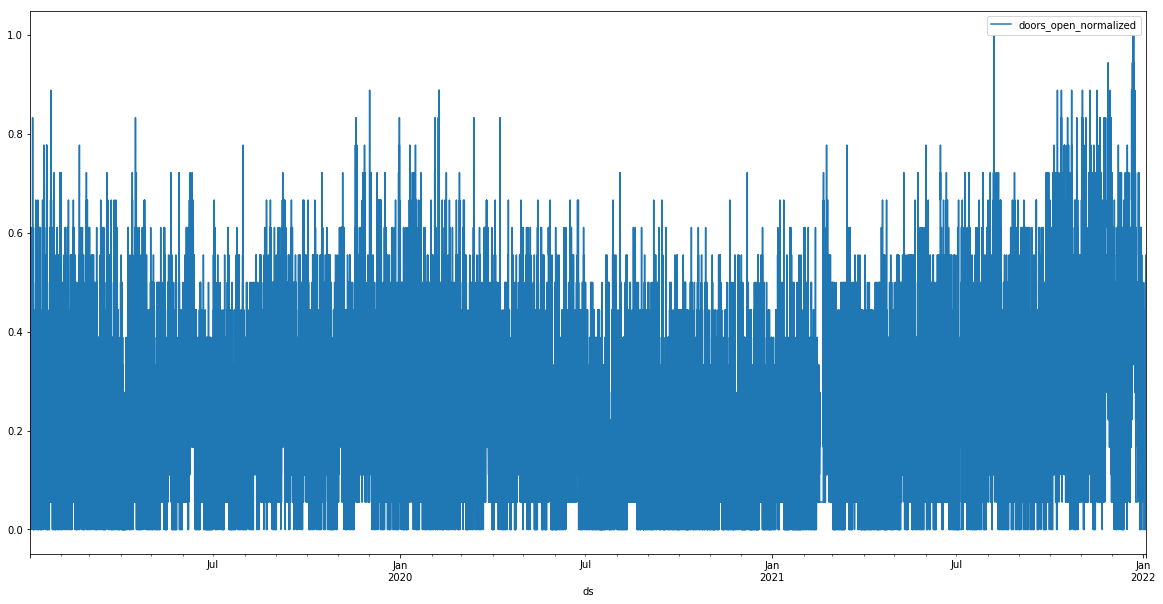

In [34]:
new_df_forplotting = new_df.reset_index()
new_df_forplotting.rename(columns = {'index': 'ds'}, inplace = True)
new_df_forplotting.plot('ds', 'doors_open_normalized', figsize = (20,10))

In [35]:
from prophet.plot import plot_plotly, plot_components_plotly

"""
Function to test prophet with
all_df: all the data you have
dummy_freq: frequency of datapoints you want the model to be fitted on test{day,hour,15min, 1 min}
regressors: set of columns in new_df you want to give to the model
cross_folds: amount of cross validation slices you want to use
changepoint_prior_scales: flexibility of the model to fit
"""

def prophet_model_prediction(all_df, dummy_freq, regressors, n_splits = 5, changepoint_prior_scales = [0.05], add_month = False, add_hour = False):
    
    best_month_rmse = 100000000
    ##make dic of all combinations of the regressors(this doesnt work fuckme)
    #regressor_combinations = itertools.product(regressors)
    regressor_combinations = regressors
   
    results = {}
    new_df_forplotting = new_df.reset_index()
    new_df_forplotting.rename(columns = {'index': 'ds'}, inplace = True)
    new_df_formonthcheck = pd.DataFrame({'ds' : new_df_forplotting['ds'], 'demand_kW' : new_df_forplotting['demand_kW']})
    
    #for each frequency in dummy_freq, resample the new_df to contain datapoints with given frequency
    for freq in dummy_freq:        
        resampled_dummy_df = new_df.resample(freq).last()  
        
        
        #for each regressor combination do the following
        for regs in regressor_combinations:  
            print(regs)
            start = time.time()
            prophet_dummy_df = pd.DataFrame({'ds': resampled_dummy_df.index, 'y' : resampled_dummy_df['demand_kW']})
            ##create the prophet_dummy_df that contains the regressors, column ds, y and reset the index
            for reg in regs: 
                
                prophet_dummy_df[str(reg)] = resampled_dummy_df[reg].copy()
                
            prophet_dummy_df = prophet_dummy_df.reset_index()
            prophet_dummy_df.drop(['index'], axis = 1, inplace = True)
            
            for scale in changepoint_prior_scales:
            ##do cross validation with n_splits
                ts = TimeSeriesSplit(n_splits=n_splits)
                count = 1
                train_rmses = []
                test_rmses = []
                for train, test in ts.split(prophet_dummy_df):              
                    print(f'Starting fold {count}')
                
                ##initiate a prophet object m and add each regressor to it
                    m = Prophet()
                    if add_month:
                        m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
                    if add_hour:
                        m.add_seasonality(name='hourly', period=0.042, fourier_order=5)
                    for reg in regs:
                        m.add_regressor(reg)
                    
                #create test and trainset                
                    cv_train, cv_test = prophet_dummy_df.iloc[train], prophet_dummy_df.iloc[test]                
                    future_test = cv_test.drop(['y'], axis = 1)
                    future_train = cv_train.drop(['y'], axis = 1)               

                    cv_train
                    #fit model
                    train_start = time.time()
                    m.fit(cv_train)
                    
                                          
                    train_stop = time.time()
                
                    #to predict future, create df for the coming future month
                    predict_start = time.time()
                    month_future_minutes = m.make_future_dataframe(periods = 86000, freq = 'min', include_history = False)
                    for reg in regs:               
                        new_df_formonthcheck[str(reg)] = new_df_forplotting[reg].copy()

                    month_future_minutes = month_future_minutes.merge(new_df_formonthcheck, on = 'ds', how = 'left') 

                    y_pred_test = m.predict(future_test) 
                    y_pred_train = m.predict(future_train)
                    y_pred_month = m.predict(month_future_minutes)
                    predict_stop = time.time()                
                
                #Calc rmse
                    rmse_start = time.time()
                    train_rmse = mean_squared_error(cv_train['y'], y_pred_train['yhat'], squared=False)
                    test_rmse = mean_squared_error(cv_test['y'], y_pred_test['yhat'], squared=False)                
                    month_rmse = mean_squared_error(month_future_minutes['demand_kW'], y_pred_month['yhat'], squared=False)
                    rmse_stop = time.time()        
                    train_rmses.append(train_rmse)
                    test_rmses.append(test_rmse)
                
                #print findings
                    timings = [(train_stop - train_start), (predict_stop - predict_start), (rmse_stop - rmse_start), (rmse_stop - train_start)]
                    print("these are the taken regulators:",   regs)
                    print(f'Fold {count} train error: {train_rmse}. Test error: {test_rmse}. month error: {month_rmse}.Time taken: {timings[3]} s.')
                    count += 1
                    if month_rmse < best_month_rmse:
                        best_month_rmse = month_rmse
                        best_regs = regs
                        best_train_rmse = train_rmse 
                        print("FUCKYES", freq)
                
                all_rmses = [train_rmses, test_rmses]
                m.plot(y_pred_month)
            ##for each split, do the following
            
    return [m, test_rmse, all_rmses, timings]
            
        #print(f'Mean Absolute Error = {mae}')
        #modelname = str(regressors) + 'with frequency' + str(freq)

Results:

What to test
1. test: resample data so that it is per hour/minute/15minutes/day. Minute data will be only of 2021, using y2021_df
2. test: different regressors
3. test: test it on 1 month prediction per minute
Results
1. 
            df length        best test score    monthscore      time to fit
minute       500.000                                             fucking long
15minutes    100.000          500                                 100secs
hour         26000            500                 240
day          1048             400                 370

2. 
            df length        best score          monthscore         
temp                              500              230         this is the best     
open door                                                 
23h


none                                                230 vgm ff checken dit
3. 

Code to do the test

['Temperature_interpolated_normalized']
Starting fold 1


11:46:01 - cmdstanpy - INFO - Chain [1] start processing
11:46:02 - cmdstanpy - INFO - Chain [1] done processing


these are the taken regulators: ['Temperature_interpolated_normalized']
Fold 1 train error: 168.5495954970907. Test error: 796.1992216599562. month error: 368.79527556874984.Time taken: 21.957911014556885 s.
FUCKYES h
Starting fold 2


11:46:23 - cmdstanpy - INFO - Chain [1] start processing
11:46:29 - cmdstanpy - INFO - Chain [1] done processing


these are the taken regulators: ['Temperature_interpolated_normalized']
Fold 2 train error: 189.2823634971763. Test error: 1233.863287893905. month error: 262.2878732219093.Time taken: 20.193349599838257 s.
FUCKYES h
Starting fold 3


11:46:43 - cmdstanpy - INFO - Chain [1] start processing
11:46:54 - cmdstanpy - INFO - Chain [1] done processing


these are the taken regulators: ['Temperature_interpolated_normalized']
Fold 3 train error: 206.00215168608023. Test error: 571.0201736112547. month error: 231.29188815661666.Time taken: 26.66774082183838 s.
FUCKYES h
Starting fold 4


11:47:11 - cmdstanpy - INFO - Chain [1] start processing
11:47:29 - cmdstanpy - INFO - Chain [1] done processing


these are the taken regulators: ['Temperature_interpolated_normalized']
Fold 4 train error: 196.99180577407998. Test error: 618.393131845329. month error: 223.67451734004752.Time taken: 37.26436138153076 s.
FUCKYES h
Starting fold 5


11:47:49 - cmdstanpy - INFO - Chain [1] start processing
11:48:13 - cmdstanpy - INFO - Chain [1] done processing


these are the taken regulators: ['Temperature_interpolated_normalized']
Fold 5 train error: 227.5945390174091. Test error: 715.214727068693. month error: 244.3150505881758.Time taken: 41.64600729942322 s.


C:\Users\sonja\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\sonja\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


"\n['weight_1h_normalized','Relative Humidity_interpolated_normalized',\n       'Temperature_interpolated_normalized', 'weight_1h_normalized',\n       'weight_5h_normalized', 'weight_10h_normalized',\n       'weight_23h_normalized', 'pallet_movement_5min_normalized',\n       'doors_open_normalized']\n"

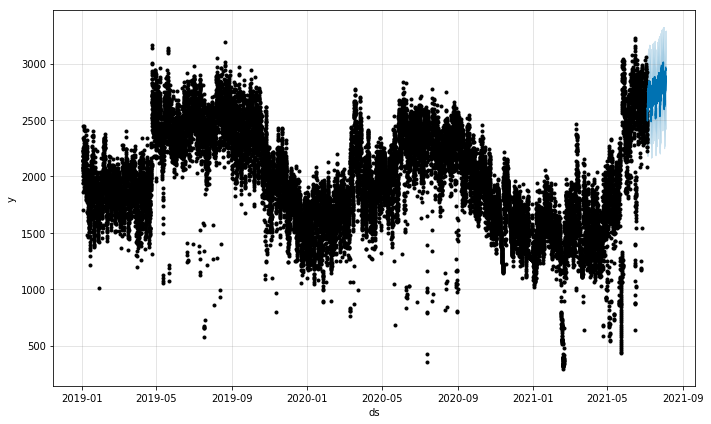

In [36]:
prophet_model_prediction(new_df, ['h'], [['Temperature_interpolated_normalized']], changepoint_prior_scales = [0.5])

#prophet_model_prediction(new_df, '[h, 15min, d]',['Temperature_interpolated_normalized'] )
#prophet_model_prediction(new_df,['Temperature_interpolated_normalized'] )
#prophet_model_prediction(new_df,['Temperature_interpolated_normalized'] )
"""
['weight_1h_normalized','Relative Humidity_interpolated_normalized',
       'Temperature_interpolated_normalized', 'weight_1h_normalized',
       'weight_5h_normalized', 'weight_10h_normalized',
       'weight_23h_normalized', 'pallet_movement_5min_normalized',
       'doors_open_normalized']
"""


In [37]:
prophet_model_prediction(y2021_df, ['min'], [['Temperature_interpolated_normalized']], changepoint_prior_scales = [0.1, 0.05, 0.01])

['Temperature_interpolated_normalized']
Starting fold 1


11:48:45 - cmdstanpy - INFO - Chain [1] start processing
11:56:10 - cmdstanpy - INFO - Chain [1] done processing


these are the taken regulators: ['Temperature_interpolated_normalized']
Fold 1 train error: 155.9927960875624. Test error: 1047.7513648501297. month error: 404.51655245394255.Time taken: 1093.144980430603 s.
FUCKYES min
Starting fold 2


12:07:14 - cmdstanpy - INFO - Chain [1] start processing
12:19:45 - cmdstanpy - INFO - Chain [1] done processing


these are the taken regulators: ['Temperature_interpolated_normalized']
Fold 2 train error: 180.5310660857698. Test error: 1164.287591883726. month error: 241.54365244844277.Time taken: 8671.748996973038 s.
FUCKYES min
Starting fold 3


14:32:00 - cmdstanpy - INFO - Chain [1] start processing
14:46:42 - cmdstanpy - INFO - Chain [1] done processing


MemoryError: Unable to allocate 5.89 GiB for an array with shape (1000, 790396) and data type float64

#### Random Forest

In [ ]:
parameter_settings_RF = {
    'n_estimators': [10, 20, 50],
    'criterion': ['squared_error']#,
    #'max_depth': [2, 4, 6],
    #'min_samples_split': [2, 4, 8]
}
data = [X_train, Y_train, X_test, Y_test]
model_RF = RandomForestRegressor
#test_RF = model_optimizer(data, RandomForestRegressor_RF, parameter_settings_RF)

#### Gradient Boosting

Theory says: start with high n_estimators (between 100 and 500) and high max_leaf_nodes (between 2 and 8) and adjust learning_rate

Higher n_estimators works better, but more time expensive, 500 trees takes like 3 minutes to fit
Lower learning rate makes worse, but after 600, the n_estimators gain is not that much anymore.

max_leaf_nodes makes better, but 

max_leaf_nodes x learning rate: 
for small n_estimators; small learning rate, is smaller effect of more leaf_nodes 
for big n_estimators; small learning rate, is smaller effect of more leaf_nodes

max_leaf_nodes x n_estimators
Bigger positive effect of max_leaf_nodes when n_estimators is increased

learning rate x n_estimators
Learning rate makes a lot of the difference. 
The effect of learning rate becomes bigger as n_estimators increases. We jump from 0.1, 0.005, 0.001. The learning rate delta that gains the most positive effect becomes a smaller learning rate as n_estimators increases, which means that into the extreme, the effect of more n_estimators with learning rate 0.1 becomes nothing and then learning rate 0.005 will outperform maybe. 
Does this mean that learning rate of 0.05/0.01 will do better? 

Best combination is 
accuracy is 148: n_estimators = 500, learning rate = 0.1, max_leaf_nodes = 7. 
accuracy is 146: n_estimators = 600, learning rate = 0.05, max_leaf_nodes = 11. 
accurcay is 144: n_estimators = 700, learning rate = 0.05, max_leaf_nodes = 11. 

accuracy is 134: n_estimators = 600, learning rate = 0.1, max_leaf_nodes = 11

accuracy is 93: n_estimators = 800, learning_rate: 0.1, max_leaf_nodes : None, max_depth: 8

accuracy is 78: n_estimators = 800, learning_rate: 0.1, max_leaf_nodes : None, max_depth: 11

optimizing parameters:
n_estimators: [50, 100, 200, 300, 400, 500], ##higher number creates more accuracy but 1000 is too much because it takes like 60000 seconds to finish the algorithm
loss: ['huber'], 
learning_rate: [0.1, 0.005, 0.001], ##lower learning rate makes worse fitting, no of max_leaf_nodes and n_estimators this effect
max_leaf_nodes: [3, 5, 7],
max_depth: [None]



In [ ]:
parameter_settings_GB =    {
    
    'n_estimators': [100],
    'loss': ['squared_error'], 
    'learning_rate': [0.1],
    'max_leaf_nodes': [None],
    'max_depth': [9, 10, 11]
}

test_GB = model_optimizer(data, model_GB, parameter_settings_GB)

In [ ]:
parameter_settings_good_GB =    {
    
    'n_estimators': [800, 1000],
    'loss': ['huber'], 
    'learning_rate': [0.1],
    'max_leaf_nodes': [None],
    'max_depth': [6, 7,8]
}

test_GB = model_optimizer(data, model_GB, parameter_settings_good_GB)


In [ ]:
parameter_settings_GB = {
    'n_estimators': [600, 800, 1000],
    'loss': ['huber'], 
    'learning_rate': [0.1],
    'max_leaf_nodes': [5, 8, 11],
    'max_depth': [None]
    
}
data = [X_train, Y_train, X_test, Y_test]
model_GB = GradientBoostingRegressor


In [ ]:
test_GB = model_optimizer(data, model_GB, parameter_settings_GB)

In [ ]:
test_GB = model_optimizer(data, model_GB, parameter_settings_GB)
   # 'n_estimators': [600, 700, 800],
   # 'loss': ['huber'], 
   # 'learning_rate': [0.05, 0.01, 0.005],
   # 'max_leaf_nodes': [5, 8, 11],
   # 'max_depth': [None]
    

In [ ]:
test_GB = model_optimizer(data, model_GB, parameter_settings_GB)
    #'n_estimators': [50, 100, 200, 300, 400, 500],
    #'loss': ['huber'], 
    #'learning_rate': [0.05, 0.01], 
    #'max_leaf_nodes': [5, 7, 9],
    #'max_depth': [None]

In [ ]:
test_GB = model_optimizer(data, model_GB, parameter_settings_GB)
#parameter_settings_GB = {
#    'n_estimators': [50, 100, 200, 300, 400, 500],
#    'loss': ['huber'], 
#    'learning_rate': [0.1, 0.005, 0.001], 
#    'max_leaf_nodes': [3, 5, 7],
#    'max_depth': [None]

Evaluating Gradient Boosting
feature importance --> 
Generalizing out of distribution --> cross validation
evaluation metric --> Mean Absolute Error




In [ ]:
current_model_GB = GradientBoostingRegressor()

In [ ]:
parameter_settings_good_GB =    {
    
    'n_estimators': [800],
    'loss': ['huber'], 
    'learning_rate': [0.1],
    'max_leaf_nodes': [None],
    'max_depth': [11]
}
current_model_GB = GradientBoostingRegressor
Results_GB = model_optimizer(data, current_model_GB, parameter_settings_good_GB)

#current_model_GB = current_model_GB(parameter_settings_good_GB)


In [ ]:
Results_GB.feature_importances_

## Visualizing sample set (X and Y) ~ D
I want to describe the Hypothesis space/Sample space (training set and the sample Distribution) to theorize about: 

1. Is it probable that the generalization error is similar to the empirical error?
2. What size must the number of training samples be given the amount of parameters/features we are trying to learn given the error rate/probability we chose. 

#### Describe Sample Space
The training samples we use is X_train, it is the features. We assume that all datapoints are drawn iid from distribution D. 

#### Describe Hypothesis Space
The hypothesis space is all the possible configurations your A can choose from. We try to find the best h to describe the relation between features xi and labels yi. It says that the probability that the space contains a training-consistent hypothesis with a true error rate > epsilon is lower than |H|e^{-epsilon m}.  

For decision trees, the hypothesis space is the set of possible decision trees.

#### Requirements to use PAC learning 
1. iid drawn examples
2. The Consistent Distribution Assumption: there is one probability distribution D that governs both training and testing examples.

#### Proof that a hypothesis space contains a good hypothesis, learnable with A
We want to find the probability of H containing a hypothesis with zero error on the training set and the true error rate greater than epsilon.

#### Proof that training set size m is big enough

As accuracy parameter \epsilon we pick 90% which is 0.1. With confidence parameter we pick 95% which is \delta = 0.05
We have m = 200000, so how big can our hypothesis space be?

function to calc. this can be found here:https://www.cis.upenn.edu/~danroth/Teaching/CS446-17/LectureNotesNew/colt/main.pdf on page 9. 

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
import time

def run_timeseries_model(data, model, n_splits = 5, verbose=False):
    """
    Function which receives a data and a model as input.
    Can also receive the amount of splits you want as input.
    For debugging purposes, set verbose to True.
    
    Outputs a list of:
        - The resulting model
        - The final RMSE
        - A list of the resulting Train RMSEs (per fold)
        - A list of the resulting Test RMSEs (per fold)
    """
    
    ts = TimeSeriesSplit(n_splits=n_splits)
    count = 1
    train_rmses = []
    test_rmses = []
    for train, test in ts.split(data):
        if verbose:
            print(f'Starting fold {count}')
        cv_train, cv_test = data.iloc[train], data.iloc[test]
        y_train = cv_train['demand_kW']
        x_train = cv_train.drop(['demand_kW'], axis=1)
        y_test = cv_test['demand_kW']
        x_test = cv_test.drop(['demand_kW'], axis=1)
        train_start = time.time()
        if verbose:
            print("Training model...")
        model.fit(x_train, y_train)
        train_stop = time.time()
        
        predict_start = time.time()
        if verbose:
            print("Predicting...")
        y_pred_test = model.predict(x_test)
        y_pred_train = model.predict(x_train)
        predict_stop = time.time()
        
        rmse_start = time.time()
        if verbose:
            print("Calculating rmse's...")
        train_rmse = mean_squared_error(y_train, y_pred_train)#, squared=False)
        test_rmse = mean_squared_error(y_test, y_pred_test)#, squared=False)
        rmse_stop = time.time()
        
        train_rmses.append(train_rmse)
        test_rmses.append(test_rmse)
        timings = [(train_stop - train_start), (predict_stop - predict_start), (rmse_stop - rmse_start), (rmse_stop - train_start)]
        if verbose:
            print(f'Fold {count} train error: {train_rmse}. Test error: {test_rmse}. Time taken: {timings[3]} s.')
        count += 1
    all_rmses = [train_rmses, test_rmses]
    return [model, test_rmse, all_rmses, timings]

In [ ]:
import itertools
import pickle

def find_optimal_parameters(data, model, params, n_splits=5, verbose=False):
    """
    Function which will find the optimal parameters within set boudaries.
    Receives as input:
    - The data
    - A model
    - The dictionary of parameters to optimize:
        - Key: parameter name
        - Value: List of testing parameter values.
    - The amount of Timeseries splits for crossvalidation (Standard: 5)
    - Whether information should be printed or not (Standard: False)
    """
    
    parameter_combinations = itertools.product(*params.values())
    results = {}
    count = 1
    for x in parameter_combinations:
        model_name = f'Model {count}'
        results[model_name] = [dict(zip(params.keys(), x))]
        count +=1
    lowest = 1000000000
    best_model = ""
    print(results['Model 1'])
    for model_name in results.keys():
        params_dict = results[model_name][0]
        print(f'Testing model {model_name} with parameters: {params_dict}')
        current_model = model(**params_dict)
        results[model_name].append(run_timeseries_model(data, current_model, n_splits=n_splits, verbose=verbose))
        print(results[model_name])
        print(f'Finished testing model. Test RMSE: {results[model_name][1][1]}. Time taken: {results[model_name][1][3][3]}.')
        if results[model_name][1][1] < lowest:
            lowest = results[model_name][1][1]
            best_model = model_name
    print(f"Optimization completed. Best model is {best_model} with parameters {results[model_name]}. \n RMSE is {results[model_name][1][1]}.")
    pickle.dump(best_model, open("Best_model.pkl", 'wb'))
    return results

In [ ]:
model_GB = GradientBoostingRegressor()
parameter_settings_good_GB =    {
    
    'n_estimators': [400, 600, 800],
    'loss': ['squared_error'], 
    'learning_rate': [0.1, 0.05, 0.01],
    'max_leaf_nodes': [None],
    'max_depth': [4, 6, 8]
}
parameter_settings_quick_GB =    {
    
    'n_estimators': [600],   
    'loss' : ['squared_error'],
    'learning_rate': [0.1, 0.3],
    'max_leaf_nodes': [None],
    'max_depth': [4, 8]
}

parameter_settings_qiuck_RF ={
    
    'n_estimators': [100]   
}

In [ ]:
find_optimal_parameters(new_df, GradientBoostingRegressor, parameter_settings_quick_GB, n_splits=5, verbose=True)